In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [2]:
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

train_data_path = 'data/train/'
valid_data_path = 'data/valid'
test_data_path = 'data/test/'

train_images = {}
valid_images = {}
test_images = {}

for root, dirs, files in os.walk(train_data_path):
    for dir_name in dirs:
        train_images[dir_name] = []
        for file_name in os.listdir(os.path.join(root, dir_name)):
            train_images[dir_name].append(os.path.join(root, dir_name, file_name))
        
print('\nTrain size (melanoma): ', len(train_images[classes[0]]))
print('Train size (nevus): ', len(train_images[classes[1]]))
print('Train size (seborrheic keratosis): ', len(train_images[classes[2]]))

for root, dirs, files in os.walk(valid_data_path):
    for dir_name in dirs:
        train_images[dir_name] = []
        for file_name in os.listdir(os.path.join(root, dir_name)):
            train_images[dir_name].append(os.path.join(root, dir_name, file_name))

print('\nValidation size (melanoma): ', len(train_images[classes[0]]))
print('Validation size (nevus): ', len(train_images[classes[1]]))
print('Validation size (seborrheic keratosis): ', len(train_images[classes[2]]))
            
for root, dirs, files in os.walk(test_data_path):
    for dir_name in dirs:
        train_images[dir_name] = []
        for file_name in os.listdir(os.path.join(root, dir_name)):
            train_images[dir_name].append(os.path.join(root, dir_name, file_name))
            
print('\nTest size (melanoma): ', len(train_images[classes[0]]))
print('Test size (nevus): ', len(train_images[classes[1]]))
print('Test size (seborrheic keratosis): ', len(train_images[classes[2]]))


Train size (melanoma):  374
Train size (nevus):  1372
Train size (seborrheic keratosis):  254

Validation size (melanoma):  30
Validation size (nevus):  78
Validation size (seborrheic keratosis):  42

Test size (melanoma):  117
Test size (nevus):  393
Test size (seborrheic keratosis):  90


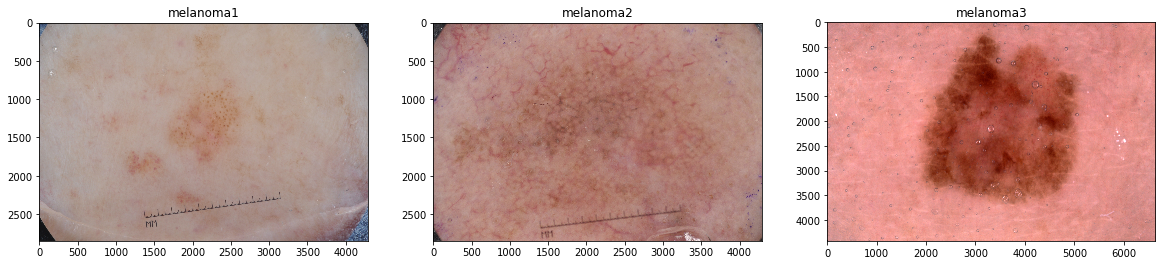

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20))

rgb_images = []
for key, val in train_images.items():
    if key == classes[0]:
        for i in range(0, 3):
            rgb_images.append(cv2.cvtColor(cv2.imread(val[i]), cv2.COLOR_BGR2RGB))
    break

for i in range(0, len(rgb_images)):
    axes[i].set_title(classes[0] + str(i + 1))
    axes[i].imshow(rgb_images[i])
    
plt.show()

In [4]:
from datasets import DermatologistDataset, Normalize, ToTensor, Resize
from nets import DermatologistNet

In [7]:
import multiprocessing as mp

size = (299, 299)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DermatologistAI:
    def __init__(self, device, num_outputs):
        self.device = device
        self.net = DermatologistNet(num_outputs).to(self.device)
        
    def train(self, train_data_path, epochs, batch_size, lr, valid_data_path=None):
        transform_ops = transforms.Compose([
            Resize(size),
            Normalize(),
            ToTensor()
        ])
        dataset = DermatologistDataset(root=train_data_path, transforms=transform_ops)
        dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=int(0.8 * mp.cpu_count()))
        
        criterion = nn.CrossEntropyLoss() # requires no softmax
        optimizer = optim.Adam(self.net.parameters(), lr=lr)
        
        for epoch in range(0, epochs):
            for i, (x_batch, y_batch) in enumerate(dataloader):
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                optimizer.zero_grad()
                
                y_hat_batch = self.net(x_batch)
                out_logits = y_hat_batch.logits
                out_aux_logits = y_hat_batch.aux_logits
                
                # Note: Should I backprop indep. from the two outputs or put them together?
                loss = criterion(out_logits, y_batch) + criterion(out_aux_logits, y_batch)
                
                loss.backward()
                
                optimizer.step()
                
        print('Done training')
        
    def infer(self):
        raise NotImplemented

In [8]:
epochs = 1
batch_size = 5
lr = 1e-3
train_data_path = 'data/train/'
valid_data_path = 'data/valid/'

net = DermatologistAI(device, len(classes))
net.train(train_data_path, epochs, batch_size, lr, valid_data_path)